# Analiza wpływu czynników na występowanie chorób sercowo-naczyniowych (CVD - Cardio Vascular Diseases)



**1. Dane:**
<p>dane pochodzą ze strony <a href="Kaggle.com">Kaggle</a>, są one zbiorem czynników dzięki którym możliwa jest estymacja prawdopodobieństwa należenia do grupy podwyższonego ryzyka związanego z chorobami sercowo-naczyniowymi (CVD)</p>


**2. Cel:**
<p>celem projektu jest analiza wpływu poszczególnych czynników na zagrożenie CVD oraz analiza statystyczna tych czynników wśród osób chorych i zdrowych</p>


### Importy bibliotek

In [1]:
from pathlib import Path
import sqlite3

import pandas as pd
import numpy as np

from copy import deepcopy

import seaborn as sns
import matplotlib.pylab as plt

from kneed import KneeLocator
from sklearn.cluster import KMeans

### Tworzę bazę danych

In [2]:
db_name = "heartDisease.db"

Path(db_name).touch()

### Tworzę tabelę sqlite

In [3]:
conn = sqlite3.connect(db_name)

c = conn.cursor()

### Ładuję plik .csv do tabeli sqlite

In [4]:
df = pd.read_csv("./Data.csv")

df.to_sql('heartDisease', conn, if_exists='append', index=False)

### Czyszczenie danych
<p>dane użyte w moim projekcie są 'czyste' pod względem brakujących wartości, wszystkie kolumny zawarte w rozpatrywanym datasecie są wypełnione. </p>
<p>W zbiore tej wielkości problemem są outlierzy, którzy niekoniecznie są bardzo odlegli od średniej/mediany/wartości oczekiwanej, natomiast są oni jedynymi reprezentantami np swojego wieku, sposobem który pomaga radzić sobie z wartościami reprezentowanymi przez pojedyncze osoby, może być klasteryzacja danych, lub całkowite odrzucenie outlierów.</p>
<p> Problematyczna może okazać się również reprezentacja zmiennej <i>ExerciseAngina</i> określającej czy ból klatki piersiowej wystąpił po wysiłu fizycznym. reprezentowanej jako <i>String</i> "Y" lub "N" </p>

 ### wyczyszczę teraz outlierów  filtrując po liczebności danej wartości w zbiorze oraz odrzucę błędne wartości

In [5]:
dirtydf = deepcopy(df)

In [6]:
# w pierwszym groupby odrzucam osoby których wiek jest unikalny itd...
df = df.\
    groupby('Age').filter(lambda x : len(x) > 1).\
    groupby('RestingBP').filter(lambda x : len(x) > 2).\
    groupby('Cholesterol').filter(lambda x : len(x) > 2).\
    groupby('MaxHR').filter(lambda x : len(x) > 1).\
    groupby('Oldpeak').filter(lambda x : len(x) > 1)

# jedna osoba w datasecie miała wartość Cholesterol = 0, co nie jest możliwe
df = df[df['Cholesterol'] > 0]
df = df[df['MaxHR'] > 0]

### poprawię reprezentacje "ExerciseAngina" 
    'Y' -> 1
    'N' -> 0

In [7]:
df["ExerciseAngina"] = (df["ExerciseAngina"] == 'Y').astype(int)

### tabela przed zastosowaniem dummy coding 

In [8]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,0,0.0,Up,0


### Zamiana nienumerycznych kolumn na DummyVariables

<p>Jak można zauważyć na powyższym wykresie, niektóre kolumny mając wartości nienumeryczne, w celu ułatwienia analizy zastosuję tzw. [Dummy Coding](https://pl.wikipedia.org/wiki/Dummy_coding)</p>
<p> zapiszę jednak wersję bazową, co ułatwi tworzenie wykresów </p>

In [9]:
nonDummyDf = deepcopy(df)

df = pd.get_dummies(df, columns = ["Sex", "ChestPainType", "RestingECG", "ST_Slope"])

### tabela po zastosowaniu dummy coding

In [10]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0.0,0,0,1,0,1,0,0,0,1,0,0,0,1
1,49,160,180,0,156,0,1.0,1,1,0,0,0,1,0,0,1,0,0,1,0
2,37,130,283,0,98,0,0.0,0,0,1,0,1,0,0,0,0,1,0,0,1
3,48,138,214,0,108,1,1.5,1,1,0,1,0,0,0,0,1,0,0,1,0
4,54,150,195,0,122,0,0.0,0,0,1,0,0,1,0,0,1,0,0,0,1


### znaczenie poszczególnych wartości:

- Age - wiek
- RestingBP - spoczynkowe ciśnienie krwi
- Cholesterol - cholesterol
- FastingBS - podwyższony poziom cukru we krwi na czczo
- MaxHR - maksymalne tętno
- ExerciseAngina - ból klatki spowodowany aktywnością fizyczną
- Oldpeak - obniżenie [segmentu ST](https://en.wikipedia.org/wiki/ST_segment#/media/File:ST_segment_elevation_and_depression.jpg) wywołane aktywnością fizyczną
- **HeartDisease - wystąpienie CVD**
- Sex_F - płeć - kobieta
- Sex_M - płeć - mężczyzna
- ChestPainType_ - ból klatki:
    - ASY - asymptomatyczny
    - ATA - nietypowa Dusznica (Atypical Angina)
    - NAP - nie dusznicowy (Non-Anginal Pain)
    - TA - typowa dusznica (Typical Angina)
- RestingECG_ - wynik elektrokardiografu
    - Normal - w normie
    - ST - nieprawidłowa fala ST-T
    - LVH - wskazujący na przerost lewej komory
- ST_Slope_ - nachylenie segmentu ST
    - Down - w dół
    - Flat - płaski
    - Up - ku górze

### Dane statystyczne każdego z czynników należącego do próby

- count - liczba rekordów
- mean - średnia
- std - odchylenie standardowe (**σ**)
- min - minimum
- 25% - kwartyl dolny (**Q1**)
- 50% - mediana
- 75% - kwartyl górny (**Q3**)
- max - maksimum

In [11]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
count,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000
mean,52.679211,132.012545,238.051971,0.161290,140.112903,0.383513,0.858602,0.458781,0.241935,0.758065,0.476703,0.236559,0.227599,0.059140,0.229391,0.602151,0.168459,0.053763,0.485663,0.460573
std,9.247988,15.956005,37.203924,0.368129,23.411236,0.486678,1.008433,0.498745,0.428640,0.428640,0.499905,0.425351,0.419658,0.236098,0.420818,0.489893,0.374609,0.225753,0.500243,0.498890
min,29.000000,100.000000,160.000000,0.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,120.000000,211.000000,0.000000,123.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,234.000000,0.000000,140.000000,0.000000,0.450000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,59.000000,140.000000,266.000000,0.000000,159.000000,1.000000,1.500000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,77.000000,200.000000,342.000000,1.000000,188.000000,1.000000,4.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Jaki ułamek wszystkich osób z próby w choruje na CVD:

In [12]:
df["HeartDisease"].value_counts(normalize=True)

0    0.541219
1    0.458781
Name: HeartDisease, dtype: float64

### Mapa cieplna korelacji poszczególnych czynników z chorobami sercowo-naczyniowymi


sprqawdzić korelacje inne ni ż liniowa


<AxesSubplot:>

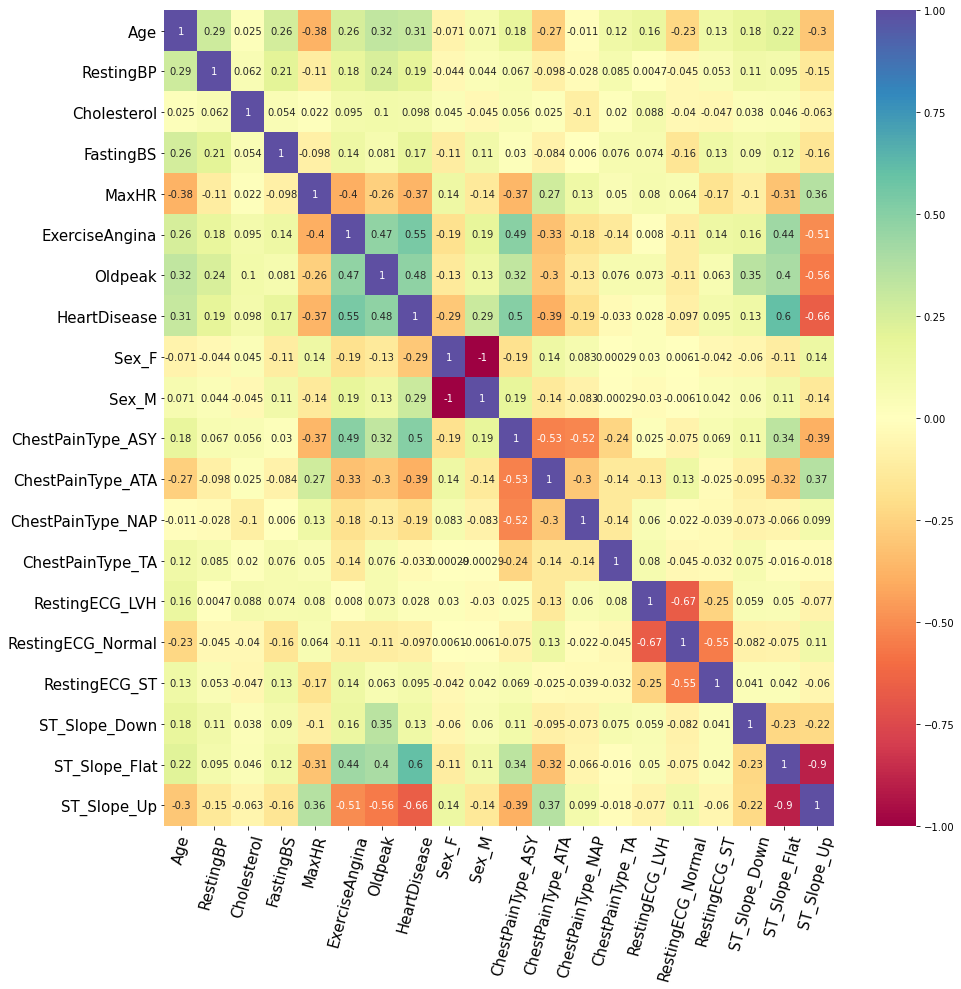

In [13]:
corr = df.corr()


fig, ax = plt.subplots(figsize=(15,15))
heatmap = sns.heatmap(corr,
           xticklabels=corr.columns,
           yticklabels=corr.columns,
           cmap="Spectral",
           annot= True, ax=ax)

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=75, fontsize=15)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=15)

heatmap

### Najbardziej skorelowane z występowaniem CVD czynniki ze zbioru to :

- **korelacja dodatnia:** 
    - **60%** ST_Slope_Flat
    - **50%** ChestPainType_ASY
    - **55%** ExerciseAngina
    - **48%** Oldpeak
    - **31%** Age
    - **29%** Sex_M

- **korelacja ujemna:** 
    - **66%** ST_Slope_Up
    - **39%** ChestPainType_ATA
    - **37%** MaxHR
    - **29%** Sex_F

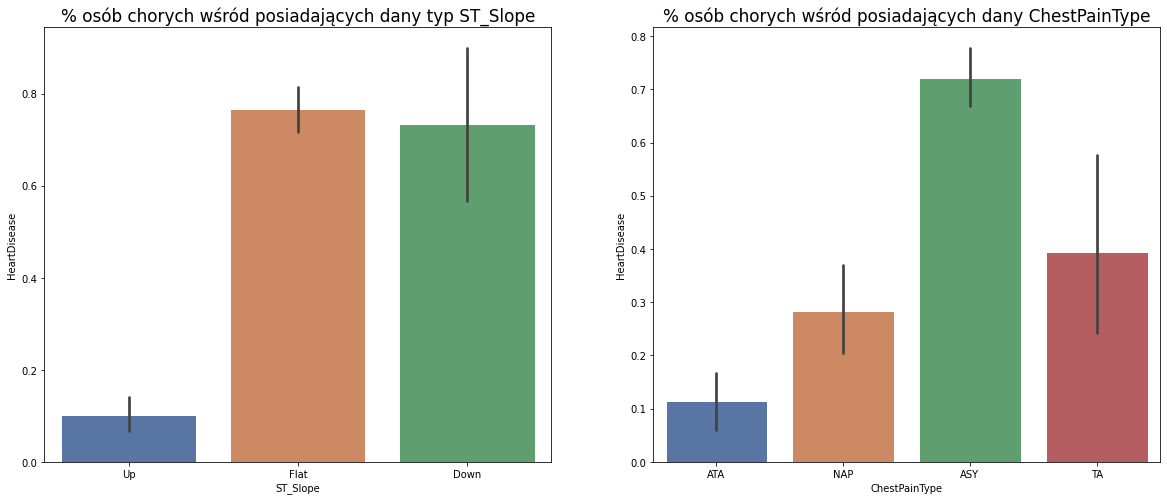

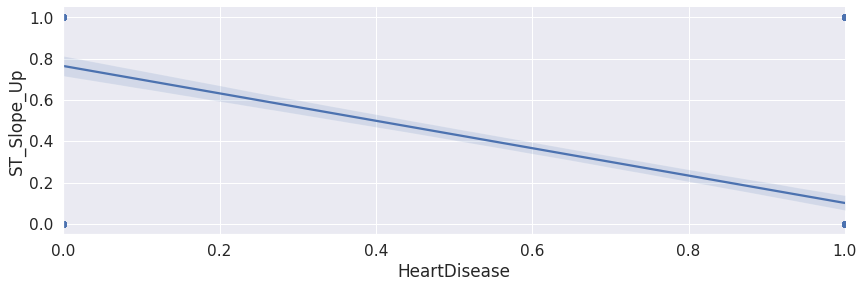

In [14]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))

sns.set(font_scale=1.4)

ax[0] = sns.barplot(x="ST_Slope", y="HeartDisease", data=nonDummyDf, ax=ax[0])
ax[0].set_title("% osób chorych wśród posiadających dany typ ST_Slope")

ax[1] = sns.barplot(x="ChestPainType", y="HeartDisease", data=nonDummyDf, ax=ax[1])
ax[1].set_title("% osób chorych wśród posiadających dany ChestPainType")

sns.lmplot(x="HeartDisease", y="ST_Slope_Up", data=df, height=4, aspect=3)

plt.show()

#### z danych widocznych na prawym wykresie można wywnioskować, iż typ bólu ASY jest symptomem wysoce korelującym z występowaniem chorób CVD, w przeciwieństwie do symptomów typu bólu ASY oraz nachylonego ku górze odcinka ST 

#### na lewym wykresie można zauważyć duży odsetek osób chorych wśród posiadających nachylenie segmentu ST w dół, jednakże na mapie cieplnej korelacji atrybutów, cecha ta nie widnieje jako posiadająca dużą korelacje, wynika to z małej liczebności osób posiadających taki typ nachylenia segmentu ST.

ps. <a href="https://en.wikipedia.org/wiki/ST_depression">Płaski segment ST</a> sam w sobie nie jest zły, problem pojawia się gdy jest on płaski i obniżony, wynika z tego że większość osób mających płaski odcinek ST widniejących w datasecie, mają również podniesiony lub opadnięty segment ST.


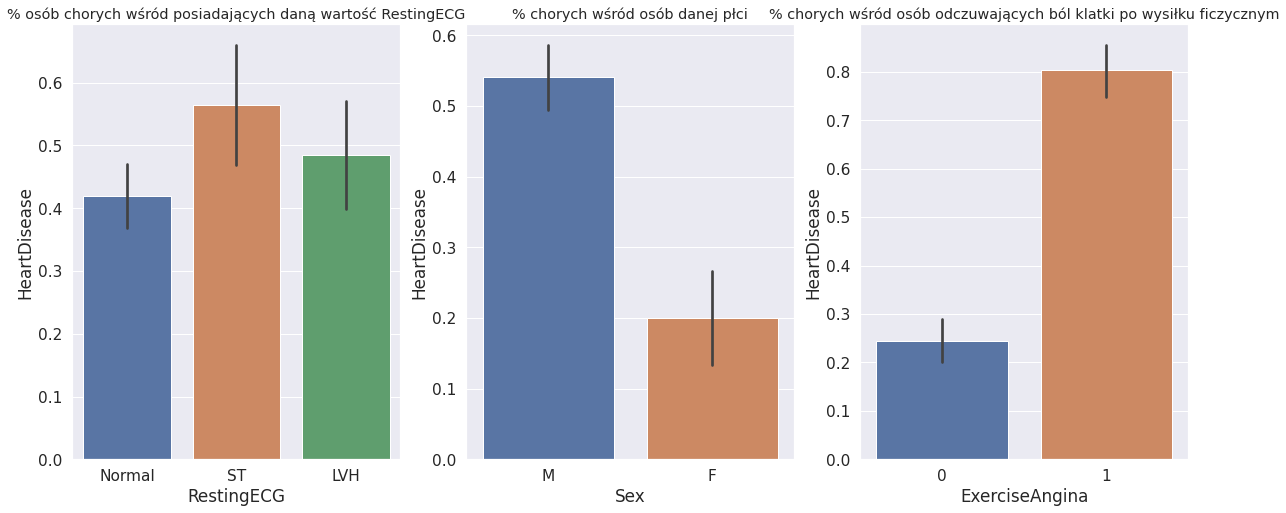

In [15]:
fig, ax = plt.subplots(1,3, figsize=(20, 8))

sns.set(font_scale=1.2)

ax[0] = sns.barplot(x="RestingECG", y="HeartDisease", data=nonDummyDf, ax=ax[0])
ax[0].set_title("% osób chorych wśród posiadających daną wartość RestingECG")

ax[1] = sns.barplot(x="Sex", y="HeartDisease", data=nonDummyDf, ax=ax[1])
ax[1].set_title("% chorych wśród osób danej płci")

ax[2] = sns.barplot(x="ExerciseAngina", y="HeartDisease", data=nonDummyDf, ax=ax[2])
ax[2].set_title("% chorych wśród osób odczuwających ból klatki po wysiłku ficzycznym")

plt.show()

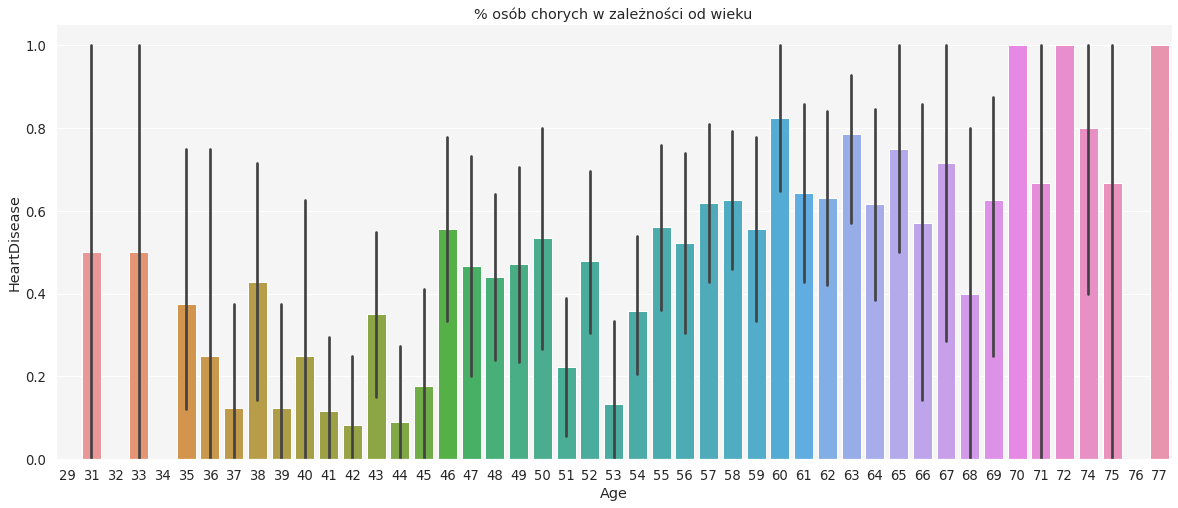

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.set(font_scale=1.2)

ax = sns.barplot(x="Age", y="HeartDisease", data=nonDummyDf)
ax.set_facecolor("#f5f5f5")
ax.set_title("% osób chorych w zależności od wieku")

plt.show()

<p>Zestawienie zależności wieku od zachorowalności nie mówi nam wiele, z uwagi na wielkość próby i rozproszenie danych nie jest ona reprezentatywna (np dla osób w wieku 77 lat 100% jest chorych)</p>
<p>Można spróbować uśrednić te dane tworząc klastry danych grup wiekowych, wielkosć i rozkład klastrów można wyznaczyć posługując się biblioteką sklearn, aby wyznaczyć najlepszą liczbę klastrów i ich rozkład</p>

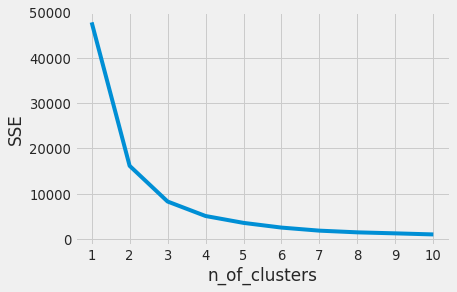

In [17]:
dataset = df[["HeartDisease", "Age"]].values

kmeans_kwargs = {
        "init": "random",  # jaki stan początkowy klastrów
        "n_init": 20,      # ile razy zacząć
        "max_iter": 100,   # maksymalna liczba iteracji
        "random_state": 42,# random seed
    }


sse = [] # lista będzie trzymała wartości SSE (Sum Squared Error) dla każdego k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataset)
    sse.append(kmeans.inertia_)

plt.style.use('fivethirtyeight')
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("n_of_clusters")
plt.ylabel("SSE")
plt.show()

<p>Teraz aby wyznaczyć <b>'knee'</b>  posłużę się KneeLocator, znajdującym najbardziej optymalną liczbę klastrów</p>
<p>Dodatkowo dodam kolumne AgeCl w dataframie jako sklasteryzowaną wartość wieku</p>

In [18]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
n_of_clusters = kl.elbow

kmeans = KMeans(
    init='random',
    n_clusters = n_of_clusters,
    n_init=50,
    max_iter=500,
    random_state=42
    )

kmeans.fit(dataset)

df['AgeCl'] = kmeans.predict(df[["HeartDisease", "Age"]])

# df.drop(columns=["AGE"], inplace=True)

**Dla znalezionych klastrów znajdę teraz przedziały grup wiekowych im odpowiadającym**

In [19]:
print("Ilość klastrów: ", n_of_clusters)
for i in range(n_of_clusters):
    print (f'Klaster {i} ( AgeCl = {i} ): min = ' 
           + str(int(df.loc[(df["AgeCl"] == i)].min()["Age"]))
           + ",  max = " 
           + str(int(df.loc[(df["AgeCl"] == i)].max()["Age"])))


Ilość klastrów:  3
Klaster 0 ( AgeCl = 0 ): min = 29,  max = 47
Klaster 1 ( AgeCl = 1 ): min = 48,  max = 58
Klaster 2 ( AgeCl = 2 ): min = 59,  max = 77


### Wykresy zależności danych czynników od zachorowalności


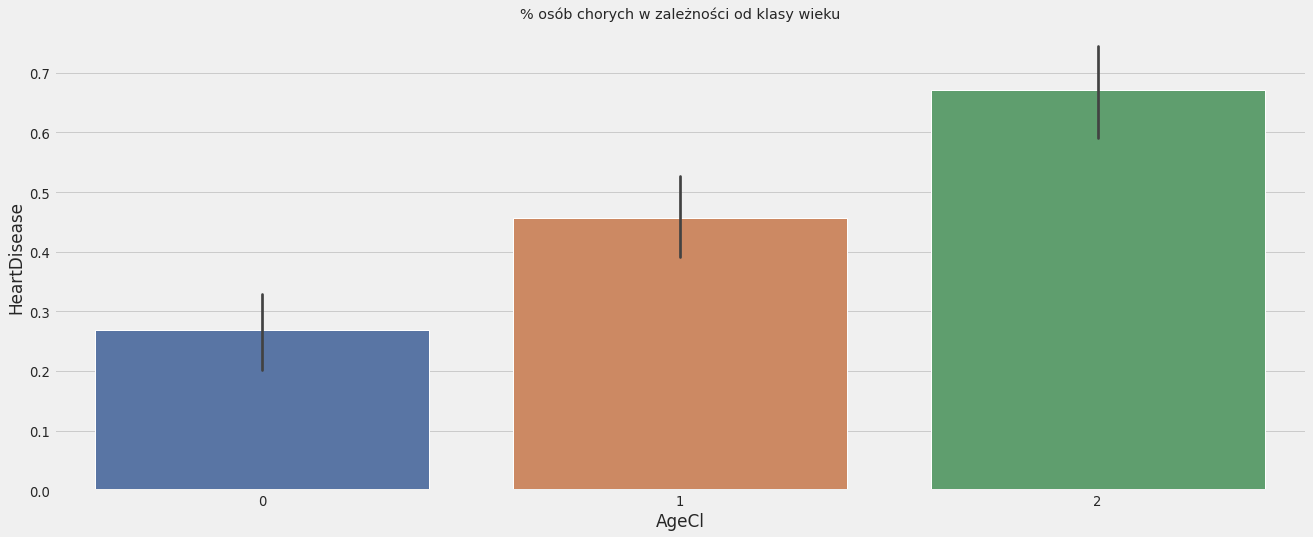

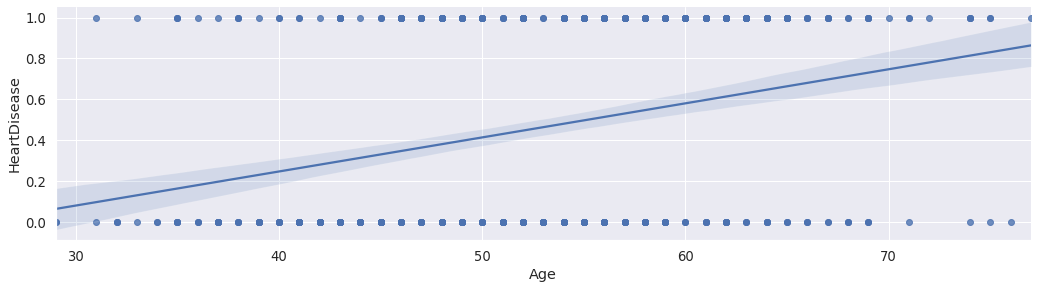

In [20]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.set(font_scale=1.2)

ax = sns.barplot(x="AgeCl", y="HeartDisease", data=df)
ax.set_title("% osób chorych w zależności od klasy wieku")

sns.lmplot(x="Age", y="HeartDisease", data=df, height=4, aspect=3.6)

plt.show()

### Wniosek:
wiek w dużej mierze przyczynia się do wzrostu ryzyka zachorowania na CVD

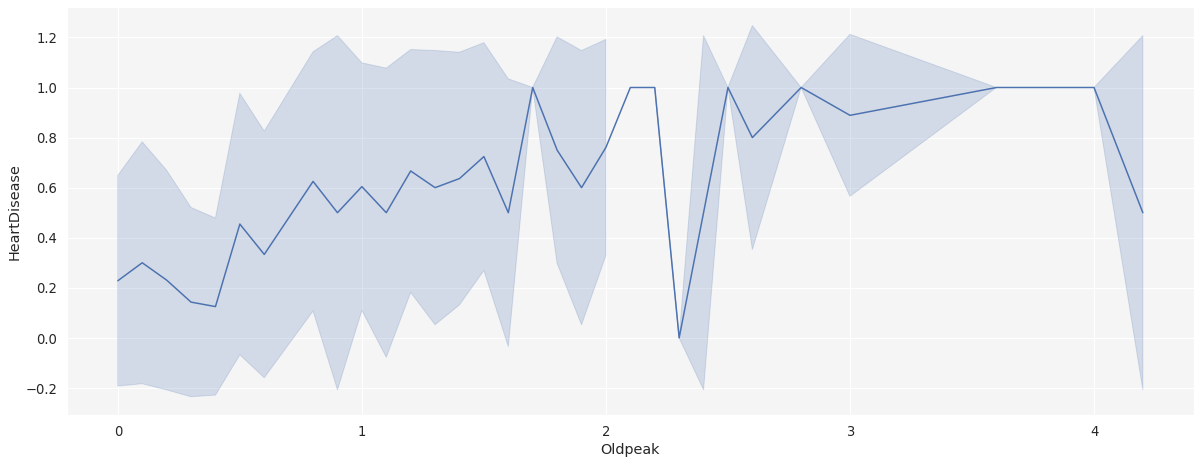

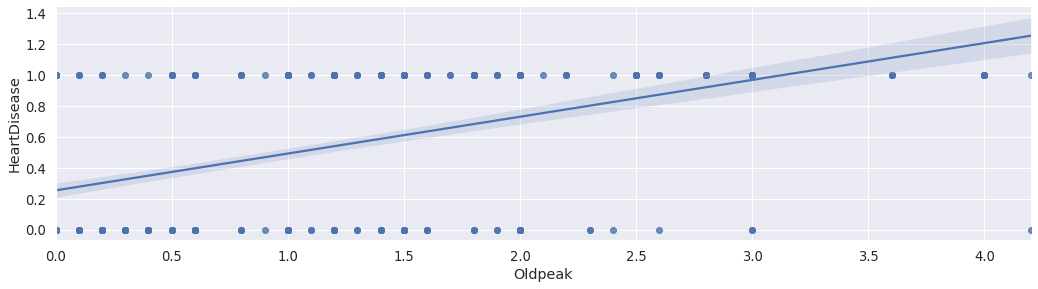

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(18,7))
sns.lineplot(x="Oldpeak", y="HeartDisease", data=nonDummyDf, ci="sd", ax=ax)
ax.set_facecolor('#f5f5f5')

sns.lmplot(x="Oldpeak", y="HeartDisease", data=df, height=4, aspect=3.6)

plt.show()

### Wniosek:
wartość oldpeak (ST depression) podobnie do wieku przyczynia się do wzrostu prawdopodobieństwa zachorowania na CVD

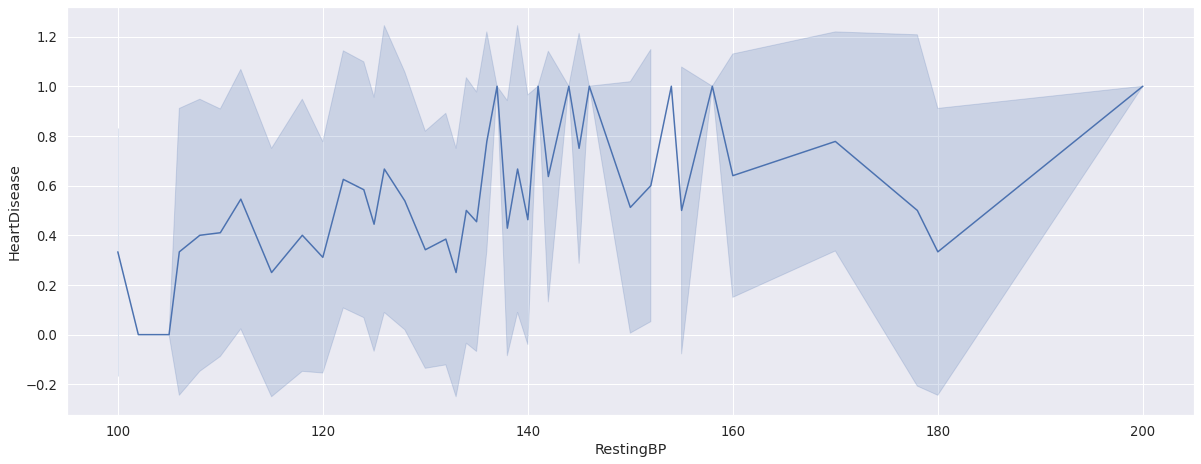

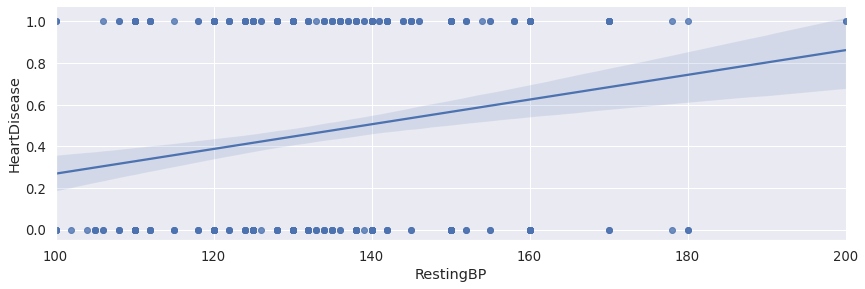

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(18,7))
sns.lineplot(x="RestingBP", y="HeartDisease", data=nonDummyDf, ci="sd", ax=ax)

sns.lmplot(x="RestingBP", y="HeartDisease", data=df, height=4, aspect=3)
plt.show()

### Wniosek:
Wysokie spoczynkowe ciśnienie krwi także może być symptomem wysoce korelującym z chorobami CVD

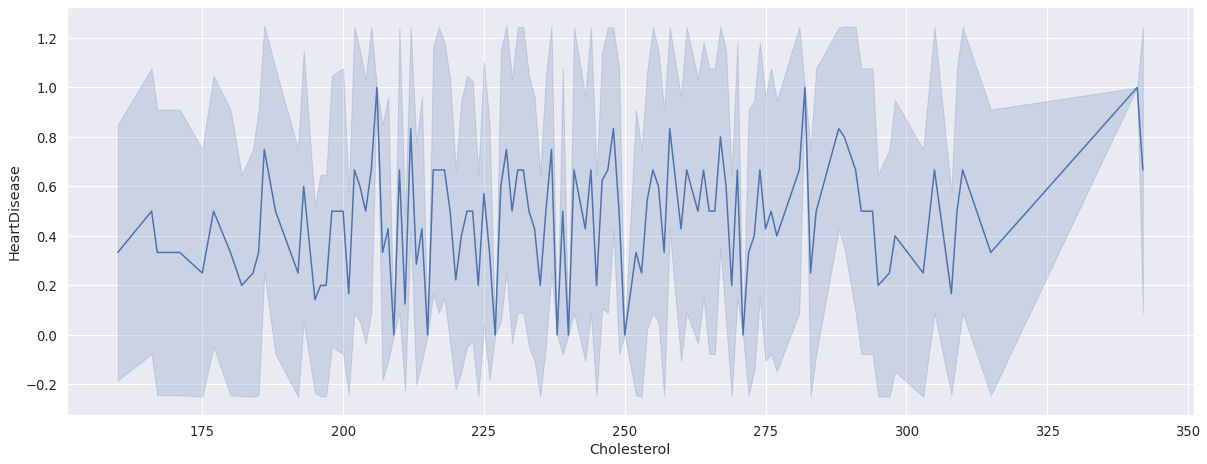

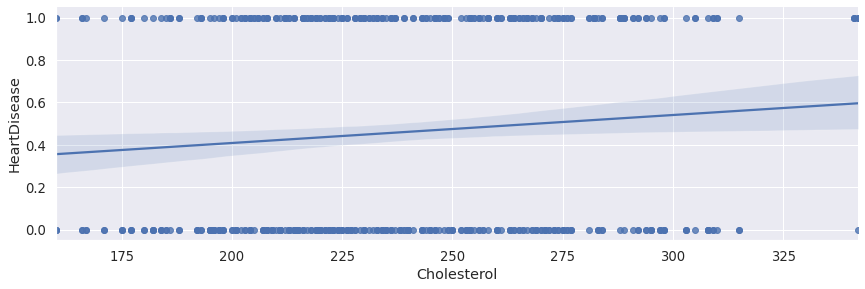

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(18,7))
sns.lineplot(x="Cholesterol", y="HeartDisease", data=nonDummyDf, ci="sd", ax=ax)

sns.lmplot(x="Cholesterol", y="HeartDisease", data=df, height=4, aspect=3)
plt.show()

### Wniosek:
Zależność poziomu cholesterolu od ryzyka zachorowania na CVD nie wynika wprost z powyższego wykresu, korelacja istnieje, natomiast jest ona bardzo mała